In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading data

In [2]:
#df_footprint = pd.read_parquet('F:/2024_Lightning_Analysis/FY-2E_data/data_extracted\\2018_part_0_small_ALL_data_with_lightning.parquet')
#df_station = pd.read_parquet('F:/2024_Lightning_Analysis/FY-2E_data/data_extracted\\around_station_small.parquet')
df_footprint = pd.read_parquet('F:/2024_Lightning_Analysis/FY-2E_data/data_extracted\\2018_part_3_of_6_ALL_2018_data_with_lightning.parquet')
df_station = pd.read_parquet('F:/2024_Lightning_Analysis/FY-2E_data/data_extracted\\around_station_2018_part_3_of_6_small.parquet')

In [3]:
print(df_footprint.shape)
print(df_station.shape)

(11852748, 25)
(137172, 25)


In [4]:
# Print the column names of the dataframe
print(df_station.columns)

Index(['File_Name', 'Cloud_Number', 'Area', 'Center_lonlat_1',
       'Center_lonlat_2', 'Eccentricity', 'Orientation', 'TBBmax', 'TBBmean',
       'TBBmedian', 'TBBmin', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Second', 'Latitude', 'Longitude', 'Error of location',
       'Number of discharges', 'Number of day', 'Lightning is in cloud',
       'Lightning is in ellipse', 'TBB near lightning'],
      dtype='object')


In [8]:
df_station['Month']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1659    1.0
1660    1.0
1661    1.0
1662    1.0
1663    1.0
Name: Month, Length: 1664, dtype: float64

## Diurnal cycle

In [13]:
def calculate_local_time(df):
    # Use .loc to modify the DataFrame safely
    df = df.copy()  # Create a copy to avoid the SettingWithCopyWarning
    
    # Calculate local time by adding the time zone offset to the UTC time
    df.loc[:, 'local_hour'] = df['Hour'] + df['Longitude'] / 15.0 + df['Minute'] / 60.0 + df['Second'] / 3600.0
    
    # Adjust for local time overflow or underflow (values < 0 or > 24)
    df.loc[:, 'local_hour'] = df['local_hour'] % 24  # Modulus operation to wrap time in 24-hour format
    
    return df

def plot_diurnal_variation(df_0, df_1=None, month=None):
    # Filter by month if provided
    if month is not None:
        df_0 = df_0[df_0['Month'] == month]
        if df_1 is not None:
            df_1 = df_1[df_1['Month'] == month]

    # Calculate local time for the datasets
    df_0 = calculate_local_time(df_0)
    if df_1 is not None:
        df_1 = calculate_local_time(df_1)

    # Bin the data by local time (use smaller bins for a more detailed diurnal cycle)
    bins = np.linspace(0, 24, 100)
    
    # Plot the histogram for df_0
    plt.hist(df_0['local_hour'], bins=bins, density=True, alpha=0.5, label='footprint')

    # Plot the histogram for df_1 if provided
    if df_1 is not None:
        plt.hist(df_1['local_hour'], bins=bins, density=True, alpha=0.5, label='station')

    # Plot settings
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Diurnal Variation for Month {month}' if month else 'Diurnal Variation')
    plt.legend()
    plt.grid(True)
    plt.show()


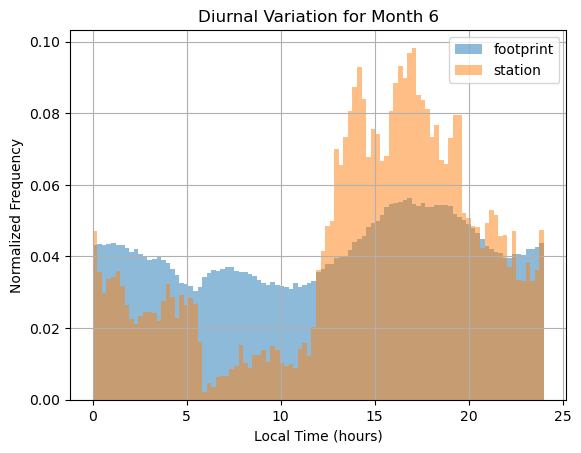

In [15]:
# df_0 and df_1 are the dataframes, and let's say we're interested in month = 7 (July)
plot_diurnal_variation(df_footprint, df_station, month=6)

In [5]:
#### не учитывает offset, не применять к большим регионам! !!!!

import plotly.graph_objs as go

def plot_diurnal_cycle_for_lightning(df_0=None, df_1=None, month=None):
    """
    Функция для построения суточного цикла разрядов молний для определённого месяца.
    Работает с одним или двумя наборами данных и строит графики на одной оси.
    
    Параметры:
        df_0 (pd.DataFrame, optional): Первый DataFrame с данными о молниях.
        df_1 (pd.DataFrame, optional): Второй DataFrame с данными о молниях.
        month (int): Номер месяца для фильтрации данных (1 - январь, 2 - февраль и т.д.).
    """
    # Убедимся, что месяц передан корректно
    if month is None or not (1 <= month <= 12):
        raise ValueError("Укажите корректный месяц от 1 до 12.")

    # Проверяем, что хотя бы один DataFrame передан
    if df_0 is None and df_1 is None:
        raise ValueError("Необходимо передать хотя бы один DataFrame (df_0 или df_1).")
    
    # Создаем пустой график
    fig = go.Figure()

    # Функция для нормировки данных
    def normalize_data(df, group_name):
        df_month = df[df['Month'] == month]
        counts_per_hour = df_month.groupby('Hour').size().reset_index(name=f'Number_of_Discharges_{group_name}')
        total_discharges = counts_per_hour[f'Number_of_Discharges_{group_name}'].sum()
        counts_per_hour[f'Number_of_Discharges_{group_name}'] /= total_discharges  # Нормировка на единицу
        return counts_per_hour

    # Обрабатываем первый набор данных, если передан
    if df_0 is not None:
        lightning_per_hour_0 = normalize_data(df_0, '0')

        # Добавляем кривую для df_0
        fig.add_trace(go.Scatter(
            x=lightning_per_hour_0['Hour'],
            y=lightning_per_hour_0['Number_of_Discharges_0'],
            mode='lines+markers',
            name=f'Набор данных 0 - Месяц {int(month)}',
            line=dict(color='blue')
        ))

    # Обрабатываем второй набор данных, если передан
    if df_1 is not None:
        lightning_per_hour_1 = normalize_data(df_1, '1')

        # Добавляем кривую для df_1
        fig.add_trace(go.Scatter(
            x=lightning_per_hour_1['Hour'],
            y=lightning_per_hour_1['Number_of_Discharges_1'],
            mode='lines+markers',
            name=f'Набор данных 1 - Месяц {int(month)}',
            line=dict(color='red')
        ))

    # Настраиваем внешний вид графика
    fig.update_layout(
        title=f'Нормированный суточный цикл разрядов молний - Месяц {int(month)}',
        xaxis_title='Местное время (Часы)',
        yaxis_title='Нормированное количество разрядов',
        xaxis=dict(tickmode='linear', dtick=1),  # Показываем каждый час
        template='plotly_dark'
    )

    # Показываем график
    fig.show()

In [6]:
# Пример использования:
# plot_diurnal_cycle_for_lightning(df_0, df_1, month=6)  # Построить графики для июня
# plot_diurnal_cycle_for_lightning(df_0, month=6)  # Построить график только для одного набора данных

plot_diurnal_cycle_for_lightning(df_footprint, df_station, 5)

## Distribution over area of clouds

In [14]:
import plotly.graph_objs as go

def plot_cloud_area_distribution(df_0, df_1=None, month=None):
    """
    Функция для построения распределения облаков по площади для двух датасетов.
    Параметры:
        df_0 (pd.DataFrame): Первый DataFrame с данными о молниях и облаках.
        df_1 (pd.DataFrame, optional): Второй DataFrame (необязательный).
        month (int, optional): Месяц для фильтрации данных.
    """

    # Фильтрация по месяцу, если передан
    if month is not None:
        df_0 = df_0[df_0['Month'] == month]
        if df_1 is not None:
            df_1 = df_1[df_1['Month'] == month]

    # Шаг 1: Группировка по уникальным облакам для df_0
    cloud_area_df_0 = df_0.groupby('Cloud_Number')['Area'].max().reset_index()  # Уникальная площадь на каждое облако

    # Подсчет количества облаков для каждого значения площади для df_0
    area_distribution_0 = cloud_area_df_0['Area'].value_counts().reset_index()
    area_distribution_0.columns = ['Area', 'Number_of_Clouds']

    # Нормировка на минимальное значение для df_0
    min_value_0 = area_distribution_0['Number_of_Clouds'].min()
    area_distribution_0['Number_of_Clouds_Normalized'] = area_distribution_0['Number_of_Clouds'] / min_value_0

    # Создаем график
    fig = go.Figure()

    # Добавляем первый график
    fig.add_trace(go.Scatter(
        x=area_distribution_0['Area'],
        y=area_distribution_0['Number_of_Clouds_Normalized'],
        mode='lines+markers',
        name='Dataset 1',
        line=dict(color='green')
    ))

    # Если есть второй датасет, то делаем то же самое для df_1
    if df_1 is not None:
        # Группировка по уникальным облакам для df_1
        cloud_area_df_1 = df_1.groupby('Cloud_Number')['Area'].max().reset_index()

        # Подсчет количества облаков для каждого значения площади для df_1
        area_distribution_1 = cloud_area_df_1['Area'].value_counts().reset_index()
        area_distribution_1.columns = ['Area', 'Number_of_Clouds']

        # Нормировка на минимальное значение для df_1
        min_value_1 = area_distribution_1['Number_of_Clouds'].min()
        area_distribution_1['Number_of_Clouds_Normalized'] = area_distribution_1['Number_of_Clouds'] / min_value_1

        # Добавляем второй график
        fig.add_trace(go.Scatter(
            x=area_distribution_1['Area'],
            y=area_distribution_1['Number_of_Clouds_Normalized'],
            mode='lines+markers',
            name='Dataset 2',
            line=dict(color='blue')
        ))

    # Настраиваем внешний вид графика
    fig.update_layout(
        title="Нормированное распределение облаков по площади",
        xaxis_title='Площадь облаков',
        yaxis_title='Нормированное количество облаков',
        yaxis_type="log",  # Логарифмический масштаб по оси Y
        xaxis_type="log",  # Логарифмический масштаб по оси X
        xaxis=dict(range=[4.2, 6.3]),  # Логарифмическое отображение для диапазона от 10^4 до 10^6.3 (~2 млн)
        template='plotly_dark'
    )

    # Показываем график
    fig.show()


In [15]:
plot_cloud_area_distribution(df_footprint, df_station, month=5) 